# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [186]:
import numpy as np
kek = [1,2,2,4,4,4,5,9]
np.argmax(np.bincount(kek))

4

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [128]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


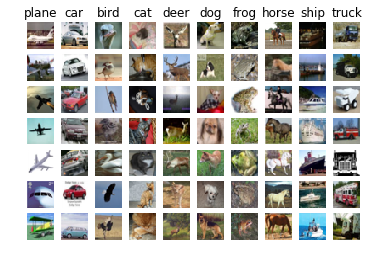

In [129]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [130]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [131]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [132]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [118]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


In [119]:
print(X_train[0])
print(X_test[0])
print(np.sqrt(np.sum(np.power(X_test[0] - X_train[0],2))))
dists[0][0]

[ 59.  62.  63. ... 123.  92.  72.]
[158. 112.  49. ...  21.  67. 110.]
3803.92350080808


3803.92350080808

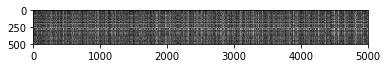

In [120]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: Из-за того, что из данных мы выбрали 5000 трейн и 500 тест образцов неравномерно, представители разных типов не уравновешены и поэтому, к примеру, самолетов может быть очень мало, а собак - много. Отсюда мы видим, что некоторые  картинки не подходят ни под один из тренировочных или тестовых образцов. Из-за чего столбец или строка с этой картинкой окрашены в намного более яркий цвет, чем большинство.



In [135]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

1
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]
[420]
[4]
[6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194 4694.09767687
 7768.33347636]
[2192]
[9]
[5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853 4464.99921613
 6353.57190878]
[4469]
[8]
[5265.83754022 4274.49459001 4593.32254474 ... 4379.85913015 3793.64455372
 6973.20378305]
[252]
[8]
[3163.80277514 4231.52395716 6134.35889071 ... 4178.39071893 3972.60292504
 3877.14405201]
[1881]
[4]
[3072.51281527 4256.22179873 5351.42317519 ... 3754.21416544 4142.64854894
 3646.74608384]
[2654]
[4]
[4184.89462233 5506.63908387 6925.23934604 ... 5038.19074669 5926.91209653
 4746.98883504]
[4033]
[3]
[3356.5065172  4486.25757174 5965.07007503 ... 4332.44169032 4558.70990523
 3726.08776064]
[910]
[2]
[4473.69858171 4363.13579894 5621.05772964 ... 4681.63112601 3155.1476986
 6142.73107013]
[4808]
[5]
[5739.62167743 4728.38555958 3968.28476801 ... 4002.40752548 4012.45274115
 6834.871

[4674.8203174  4740.34597893 5881.51154041 ... 4902.62378732 4832.98034343
 5522.47073329]
[1141]
[8]
[2524.74137289 3601.7590147  5075.51810163 ... 3110.13986824 3272.80995476
 4057.51956249]
[3847]
[2]
[2938.49161986 4269.49786275 5515.56270928 ... 3441.13237176 4212.68572291
 3273.31559737]
[1838]
[2]
[4484.43106759 4502.95780571 5286.7416241  ... 4118.65475611 4960.70055537
 5476.27720263]
[2894]
[2]
[4500.26443667 5331.55033738 6983.4918916  ... 5480.16049035 5603.43109175
 4886.80161251]
[1161]
[6]
[3265.08728827 3706.23366775 4235.49878999 ... 2802.06780789 2855.5270967
 4315.7679502 ]
[2573]
[4]
[3804.69749126 5561.30578192 6950.73046521 ... 4961.43588087 5194.30871243
 3659.82882113]
[3166]
[4]
[7679.63833784 6561.40777577 6072.1617238  ... 6386.19010052 5255.97650299
 8073.17254863]
[1178]
[0]
[5743.51138242 4953.7422218  5711.5544294  ... 5083.84500157 4279.35871364
 6588.08811416]
[2229]
[8]
[2933.95773657 4228.17655734 5817.65545559 ... 3872.40093482 4362.46696263
 4025.78

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [122]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[4 4 4 6 6]
[9 8 8 8 0]
[8 8 8 5 8]
[8 2 0 8 8]
[4 5 4 2 4]
[4 6 5 2 6]
[3 4 6 6 2]
[2 4 2 7 6]
[5 8 2 2 2]
[8 8 1 8 9]
[2 8 0 5 0]
[8 7 4 9 8]
[5 4 3 4 5]
[7 6 6 5 6]
[2 8 8 4 4]
[2 2 4 8 8]
[5 3 2 5 5]
[3 4 8 4 2]
[1 9 8 8 8]
[4 3 2 7 2]
[2 2 6 4 2]
[0 0 0 0 0]
[0 0 0 0 0]
[6 4 4 2 2]
[2 0 4 2 4]
[4 4 4 4 2]
[2 6 6 4 2]
[7 4 2 4 7]
[2 6 7 9 4]
[6 4 3 2 2]
[6 2 6 0 0]
[2 2 4 2 2]
[4 5 4 4 2]
[6 6 3 5 3]
[8 8 9 8 2]
[7 1 4 8 6]
[2 6 4 2 4]
[8 0 8 0 0]
[4 2 6 2 8]
[2 5 8 4 0]
[8 8 8 8 2]
[6 3 6 2 6]
[2 7 8 0 4]
[4 8 6 4 4]
[9 8 0 0 4]
[0 0 2 8 8]
[5 1 5 5 3]
[0 8 0 8 2]
[4 4 4 4 4]
[2 2 2 4 4]
[7 8 0 8 9]
[8 0 8 4 8]
[4 6 8 6 4]
[3 2 5 2 4]
[8 8 0 8 8]
[8 8 4 8 0]
[5 4 4 5 5]
[0 6 1 6 3]
[0 2 7 0 0]
[4 0 2 0 2]
[4 6 2 4 2]
[6 7 5 6 6]
[6 6 6 6 6]
[3 4 5 8 0]
[3 4 4 4 2]
[2 4 2 4 6]
[8 8 4 1 0]
[8 2 0 0 2]
[3 3 6 2 7]
[9 9 1 8 5]
[2 0 2 0 2]
[4 6 6 7 2]
[8 0 8 8 8]
[0 8 8 8 8]
[4 0 7 0 9]
[4 3 2 2 4]
[6 2 4 0 2]
[3 5 3 3 2]
[6 6 4 4 6]
[8 8 0 5 8]
[8 8 0 8 0]
[3 6 3 6 4]
[5 6 4 6 2]
[0 2

You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*: 4

*Your explanation*: Процедура высчитывания L1 и L2 дистанций отличается и ни один из предложенных методов ни приводит L2 к L1


In [95]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [96]:
print(X_train[0])
print(X_test[0])
dists_one[1]
print(np.sqrt(np.sum(np.power(np.subtract(X_test[0],X_train),2))))

[ 59.  62.  63. ... 123.  92.  72.]
[158. 112.  49. ...  21.  67. 110.]
318501.57929121796


In [137]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')


ValueError: operands could not be broadcast together with shapes (500,5000) (500,4000) 

In [68]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 33.431932 seconds
One loop version took 83.086226 seconds
No loop version took 0.284761 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [138]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_temp = X_train
y_train_temp = y_train
X_train_folds = np.array_split(X_train_temp,num_folds)
y_train_folds = np.array_split(y_train_temp,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = list()


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    for fold in range(num_folds):
        classifier.train(np.concatenate([x for i, x in enumerate(X_train_folds) if i != fold]),
                         np.concatenate([y for i, y in enumerate(y_train_folds) if i != fold]))
        y_test_pred = classifier.predict(X_train_folds[fold], k, num_loops=2)
        print(y_test_pred)
        num_correct = np.sum(y_test_pred == y_train_folds[fold])
        accuracy = float(num_correct) / len(y_train_folds[fold])
        print('k: ' + str(k) + ' fold: ' + str(fold) + ' accuracy: ' + str(accuracy) + '\n')
        k_to_accuracies.append(accuracy)
        
        
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################



1
[5429.76030779 4734.88574308 4855.95037042 ... 4006.57072819 4212.60180886
 4061.94017681]
[3637]
[6]
[4822.09062544 5149.88213457 5685.16499321 ... 4140.58619038 4153.84604915
 5665.2589526 ]
[3453]
[2]
[4651.24542461 6430.06049738 6278.95094741 ... 4025.00509316 4940.09807595
 7017.85658161]
[3476]
[0]
[5745.45820627 5456.69900214 4129.58290872 ... 4163.85182253 4844.51122406
 3506.59535732]
[367]
[6]
[4673.63905324 5765.98768642 5328.76449095 ... 4011.76943505 4927.82010629
 5080.54003035]
[3852]
[8]
[5699.15344591 5544.56490628 4232.98936923 ... 4078.95035518 4772.49442116
 4854.12103269]
[968]
[4]
[4712.3181132  4555.09209567 4907.98359818 ... 3861.58024648 3372.33524431
 4868.72457631]
[1764]
[2]
[5385.00798514 3972.10611641 5248.33745104 ... 4695.43427172 3845.30674979
 4595.81309455]
[1921]
[4]
[4294.02584995 5345.2736132  6707.44012273 ... 4854.76219809 4723.44312975
 5951.94127995]
[243]
[0]
[5729.18187877 6771.4087899  4317.32532941 ... 4501.36590381 5600.88064504
 4506.80

[1943]
[4]
[4566.47511764 4863.10363862 5327.58444325 ... 3511.49355688 4041.71597221
 4807.27531976]
[3224]
[4]
[5918.55886175 4777.03077235 5119.65155064 ... 4932.03355625 4087.35635833
 4254.78037036]
[276]
[7]
[6200.62311385 5892.52433173 6743.43102582 ... 5450.44282605 5232.38244015
 7256.92910259]
[186]
[9]
[4542.05636249 5621.04705549 4792.5522428  ... 3968.56472796 4644.1773222
 5290.39119537]
[323]
[8]
[5185.19257116 5211.28045686 4474.15589804 ... 4275.97544427 4510.49963973
 4271.29640742]
[2549]
[0]
[4569.31154552 4421.93554906 5528.85331692 ... 3961.73093483 3930.93258655
 5590.78679615]
[2246]
[0]
[5000.23309457 5384.88244997 4201.99428843 ... 4230.66602322 4572.96227844
 4440.94201719]
[2193]
[2]
[5022.84550828 4877.55768802 5347.12689208 ... 4484.99821628 4097.35182771
 5235.95454526]
[3045]
[8]
[5927.20650897 4871.88967445 7628.99888583 ... 5898.49650335 4844.49130456
 7097.80543548]
[3257]
[2]
[5885.0130841  5760.59797243 8721.0870882  ... 6532.41831177 4875.43700605


[1977]
[7]
[5489.65244802 4414.18916677 6693.28073519 ... 5048.28604578 4405.67509015
 5517.18923003]
[780]
[5]
[4848.36735407 5294.44406902 4489.56155989 ... 4144.76585587 4528.02705381
 4697.18224045]
[2549]
[0]
[5739.67263875 4616.74409081 5053.18345204 ... 4566.29828198 4095.60801347
 4560.09703844]
[3905]
[4]
[6518.2140959  6251.13373717 8656.8644439  ... 7059.55940552 5730.23123443
 9664.49884888]
[1707]
[0]
[4140.91692744 5478.36225527 5602.3898472  ... 3550.84849015 3914.00689831
 6457.74217509]
[1003]
[8]
[5347.64761367 6159.27682443 3370.51539086 ... 3645.12372904 5049.81445204
 4817.21143401]
[3066]
[8]
[4528.32849957 4505.72779915 4026.29979013 ... 3410.39924349 3035.57506908
 4572.79323827]
[38]
[6]
[5746.09885052 4701.60440701 6024.77626141 ... 4720.76519221 4658.99570723
 4648.82619593]
[1296]
[6]
[4525.20143198 5024.77840307 5684.22914739 ... 3547.24738354 3676.56402093
 6094.72977252]
[3954]
[3]
[4860.90310539 5060.14080832 7506.26858033 ... 5612.89310427 4062.43030709

1
[5429.76030779 4822.09062544 4651.24542461 ... 4205.26574666 4225.6697694
 6292.67613977]
[2677]
[9]
[4734.88574308 5149.88213457 6430.06049738 ... 5415.06934397 3750.67500592
 5886.7348335 ]
[1925]
[6]
[4855.95037042 5685.16499321 6278.95094741 ... 4875.60283452 5398.38105361
 5424.50901004]
[1846]
[2]
[3969.76309117 4190.76794872 4868.91897653 ... 3516.07565334 3812.62809621
 4792.3778023 ]
[1133]
[2]
[4041.24955923 4016.57428663 4124.39777422 ... 3106.00885382 2650.24527167
 4946.81089188]
[1868]
[2]
[3924.03720676 4597.65342321 4990.79462611 ... 3656.28240157 3953.83914696
 4664.87941966]
[3753]
[4]
[3219.85838198 4441.77700926 6752.66236384 ... 4690.90940011 4965.21359057
 3808.34924869]
[3660]
[4]
[3712.51505047 3800.5985055  4602.00249891 ... 3496.25385234 3402.62046076
 4986.88540073]
[2029]
[7]
[5248.54570334 5357.50361642 5542.26154201 ... 4967.53027167 3931.07313593
 6565.35071417]
[1017]
[5]
[4727.62001434 3934.39372712 4696.17120642 ... 3969.63323243 3113.68350993
 5555.

[1819]
[8]
[6864.34286731 5537.8035357  4553.29660795 ... 5098.65982391 4344.86628103
 8204.42606158]
[1065]
[8]
[3234.28585626 4334.78442371 6319.41832766 ... 4370.12333922 4028.02693635
 4091.11390699]
[1203]
[6]
[3718.99247109 4617.74988495 6590.57068849 ... 4941.96135153 5314.51681717
 5180.01013513]
[914]
[6]
[4596.71654554 4831.75371889 5034.16030734 ... 4407.91061615 3751.49130347
 5495.67093265]
[34]
[4]
[2695.4973567  3755.01331556 5036.47863095 ... 3301.42590406 3021.73261557
 4182.07388744]
[58]
[4]
[5256.77372539 4475.52935417 4063.21092241 ... 3919.20616962 3522.16524314
 6299.12216106]
[987]
[8]
[4803.25181518 3947.1479577  4789.06222553 ... 4279.65173817 3906.32871121
 6067.04475012]
[3453]
[2]
[4367.90647794 3940.11446534 4579.79912223 ... 3538.73678026 3632.58103833
 5552.35058331]
[3723]
[8]
[5039.1319689  4902.56953036 6987.29003262 ... 5445.51026076 6143.40939544
 5047.29997127]
[2113]
[0]
[4196.68106961 5020.30487122 4996.73443361 ... 4060.33951782 4849.97092775
 4

[622]
[4]
[3000.34847976 4817.2153782  6627.20016296 ... 4483.57312866 4879.0553389
 3013.97196404]
[3108]
[3]
[3919.98010199 5266.88133529 5791.69949151 ... 4189.73972939 5191.30272668
 4074.54610969]
[1337]
[3]
[3983.30817286 4446.68224635 5045.64733211 ... 3836.12395524 2770.71579199
 4934.79888141]
[254]
[4]
[5140.01721787 4433.83671328 5453.22400053 ... 4630.08142477 4228.16922556
 5269.61962574]
[1540]
[2]
[6220.89028998 5159.06764833 4814.76281867 ... 5090.42326334 4241.63105421
 8048.10859768]
[2215]
[8]
[6220.95081157 5336.0223013  5470.95439572 ... 5357.12534854 4031.39913678
 7030.22268495]
[1341]
[0]
[4993.00110154 5586.09049336 5437.37666527 ... 4647.80883858 4374.17626531
 5721.86438148]
[303]
[2]
[4085.84507783 5025.03980084 6950.80146458 ... 4877.62534437 4794.93899857
 4572.53015299]
[2790]
[5]
[6119.54802253 5458.64479518 4882.49905274 ... 5077.29544147 4009.74537845
 7447.26392711]
[2263]
[0]
[3979.58842093 4904.27334067 6248.96415416 ... 4638.32480536 3758.62049162


1
[4824.79502155 4740.09999895 3377.00103642 ... 3142.35930473 3908.81247951
 6001.71617123]
[2919]
[4]
[4295.42652131 4378.72013264 6379.49872639 ... 4462.80427534 5194.81578114
 4284.79976195]
[3463]
[5]
[4679.54014835 4546.64612654 5358.28284061 ... 4123.63298561 4111.06385258
 5172.24535381]
[592]
[8]
[5332.09142832 4060.35195519 3917.06267502 ... 3712.92849379 3959.27935362
 6888.66278751]
[185]
[0]
[3871.40400888 5677.73493569 6294.3941726  ... 4832.05980923 5508.15059707
 3336.1716083 ]
[2383]
[4]
[4419.32347764 4645.02088262 6087.19270272 ... 4506.57153499 5429.62540144
 5706.10672876]
[432]
[1]
[4769.40048643 4846.82473378 5211.13864717 ... 4515.42511841 3070.7043166
 6647.18474243]
[403]
[2]
[4381.39019034 4757.640907   5532.83064986 ... 4287.76900031 4424.7338903
 4584.31761552]
[1936]
[2]
[4495.82728761 5300.92652279 6954.72328709 ... 5355.74962073 4120.43383638
 5310.87610475]
[373]
[0]
[3128.91578666 3837.69084216 4824.54443445 ... 3335.52469636 3316.10765808
 4383.362636

[2399]
[1]
[4126.04423146 4146.65769024 4154.62513351 ... 3379.83816181 3323.11976913
 4882.86463052]
[3277]
[8]
[4404.3988239  5038.2483067  4569.15112466 ... 3772.44005917 4914.31002278
 5095.23179061]
[1480]
[8]
[5854.20925489 5584.52782248 5029.18233911 ... 4906.27567509 3465.14328708
 6935.27634633]
[3431]
[2]
[3393.13674938 4598.72025677 5769.70345858 ... 3935.5858522  4464.90302246
 4206.61110634]
[2229]
[5]
[5151.96768235 5353.37837258 6212.10270359 ... 5141.57466152 4189.00310336
 5384.34759279]
[3898]
[7]
[2770.66381938 4138.25941671 5202.61367007 ... 3446.75978275 3360.88291971
 3661.64580483]
[2684]
[4]
[6124.00938928 5747.45056525 7179.51432898 ... 6205.86351767 4921.88510634
 6340.45637159]
[129]
[0]
[3894.80423128 5025.24118824 6468.79826552 ... 4748.57062704 4448.32013236
 4046.31239526]
[551]
[7]
[4893.59939104 4482.2998561  4550.8636543  ... 4012.24002273 2784.23077348
 5958.3639533 ]
[3617]
[8]
[3293.73921251 5547.2134446  6443.57408586 ... 4547.42597521 5173.9031687

[869]
[3]
[4057.53890924 4727.63566701 6223.23348429 ... 4457.03253298 5468.88014131
 4159.26195376]
[710]
[6]
[3973.75263448 4019.86305737 4803.48841989 ... 3818.92720538 3272.22829277
 4766.53060412]
[2164]
[2]
[3344.81195286 4673.72421095 6339.46133358 ... 4329.99445727 3816.08058091
 4348.78983167]
[2418]
[4]
[3156.38178933 4650.13451418 5815.88849618 ... 4020.79258356 4903.03212308
 3412.91371119]
[910]
[2]
[5060.47813946 4857.53703022 3913.48846938 ... 3635.43807539 4926.4093415
 5964.65497745]
[170]
[8]
[5259.94752826 4774.3189043  4367.90670688 ... 4194.49842055 3082.71179321
 6490.9211981 ]
[144]
[2]
[5189.5065276  5103.42953317 5786.23945236 ... 4583.54044381 4281.15264853
 6101.74860184]
[2798]
[4]
[3665.01227829 3840.1643194  4661.59929638 ... 3123.06195904 2367.65685858
 5044.86977037]
[2376]
[3]
[4915.17629389 3864.33293079 3992.30472284 ... 3433.08010393 3596.6434352
 6244.13372695]
[3477]
[0]
[6209.72374587 4603.20605665 4656.15420707 ... 4891.0064404  4013.25316919
 76

1
[4796.67009497 5253.95060883 5127.9047378  ... 4046.27075219 4335.44346059
 5684.19809648]
[1624]
[4]
[5414.64283217 4941.42388386 4501.1478536  ... 4207.54584051 3352.67490222
 6193.3749281 ]
[2868]
[2]
[4055.82445379 5330.30308707 6436.92216824 ... 4551.43307102 5185.51771764
 4040.37770512]
[2812]
[2]
[4942.11442603 5685.32831066 7098.88639154 ... 5640.23917933 5979.4520652
 3730.88823204]
[3089]
[3]
[5860.45578432 6217.95858783 5798.9044655  ... 5167.15134286 3952.79597247
 7052.49757178]
[2710]
[4]
[5088.27898213 5179.79748639 6050.77003364 ... 4754.45454285 4353.11578068
 5258.78987981]
[2017]
[5]
[5680.70955075 5248.41614204 4280.68102059 ... 4430.99198826 4982.57212692
 6791.62108778]
[3134]
[7]
[5809.09769241 5808.5074675  4031.57277002 ... 4155.40455311 4862.35416234
 6219.13386252]
[1125]
[7]
[4887.49168797 4625.90358741 3967.79182922 ... 3643.09209326 3659.59984151
 5902.14274649]
[982]
[4]
[5578.34357135 4616.04982642 4688.12094554 ... 4528.27649333 3848.19087364
 6459.1

[2922]
[4]
[4419.7702429  5244.52705208 5438.60809399 ... 4484.45983369 4643.30518058
 5012.18126169]
[2595]
[2]
[4043.70993025 4001.05623555 4901.28768794 ... 3896.35842807 3956.37839444
 5064.7615936 ]
[1677]
[2]
[5236.12776773 4720.65980558 3263.78078308 ... 3263.02911418 3691.51594877
 6046.09626123]
[3053]
[4]
[4532.31519204 4406.54082019 5694.87471328 ... 4466.19905513 4934.06982115
 5360.67281225]
[1728]
[4]
[7390.81544892 6196.13637681 6069.13964249 ... 6056.49816313 4529.28040642
 8557.55426509]
[2441]
[8]
[3456.46683768 5223.12416088 6025.32521944 ... 4226.23520406 4828.62827312
 3136.62222781]
[1530]
[2]
[4529.54887378 4292.0603444  6409.0436104  ... 4786.15294365 4759.23113538
 6077.84131086]
[773]
[8]
[5299.63140228 5523.99112961 6787.4618231  ... 5642.34844723 5259.01197945
 5321.86668379]
[3350]
[3]
[5964.84484291 6154.87473471 5237.57205201 ... 4829.69988716 4974.52470091
 7095.66022298]
[2893]
[6]
[7057.31967534 5985.60139    5783.46902819 ... 5919.75100828 4810.497999

[1732]
[8]
[5091.67025641 4397.8998397  5620.15293386 ... 4729.05794001 4458.07065893
 6354.17264481]
[3453]
[2]
[4970.73002687 5514.05422534 5442.71035423 ... 4628.42089702 4937.37916308
 5139.64288643]
[2887]
[1]
[3851.94626131 3778.00436739 5087.7188405  ... 3656.33108457 2928.31999618
 5049.37956585]
[2796]
[6]
[3480.00804597 4454.05332254 4603.44620909 ... 3384.43333514 3962.53807553
 3866.80022758]
[3007]
[3]
[4583.51295406 4546.61478465 5388.3899265  ... 4080.91435833 4317.99339972
 5244.01516016]
[1500]
[2]
[4836.11559002 3896.14001288 4335.20322476 ... 3801.53824129 3445.11044816
 5707.90889906]
[3320]
[8]
[3904.01600919 4317.42955936 6299.53585592 ... 4554.41017037 4599.18547136
 4018.65537214]
[1881]
[4]
[5204.06331629 6240.44982353 7883.21457275 ... 6143.31181042 5714.3383694
 6289.72328485]
[1198]
[5]
[6157.95412454 6637.209504   5685.59724215 ... 5332.16485117 5525.10334745
 6761.29358925]
[3142]
[9]
[4352.52294652 3818.46657704 4168.9829695  ... 3164.10097816 3606.659118

1
[4639.17147775 4150.04204798 6078.16822735 ... 4574.69244868 6173.21796148
 6273.58358516]
[3458]
[6]
[5316.76142026 5007.02895937 6562.17776352 ... 5625.18381922 6686.1434325
 6551.39687395]
[402]
[2]
[4323.06072129 3837.79689405 5308.50346143 ... 4282.69809816 5314.82567917
 5683.58487224]
[402]
[2]
[6291.69476373 5662.77546791 4032.36828675 ... 4760.10167959 3745.50517287
 7275.74862128]
[1058]
[8]
[3263.84726971 4644.40868141 5859.77508101 ... 3633.49391082 5600.72182848
 3886.30364228]
[1126]
[6]
[4780.62506373 3778.04592349 4735.29777311 ... 4240.41189037 4981.3299429
 5976.6809351 ]
[1141]
[8]
[4420.04649297 5428.31723465 6131.65426292 ... 4203.47118463 6025.47500202
 5879.3103337 ]
[3206]
[5]
[3191.41473331 4077.30536016 4842.58536321 ... 3249.94630725 4903.12940886
 3603.76150709]
[420]
[4]
[4802.55640258 5165.09196433 6086.2053038  ... 4530.47933446 5954.90201431
 5335.47739195]
[1164]
[3]
[4081.27382076 3697.55040534 5328.58039256 ... 4043.22433214 5418.7993135
 5368.02263

[2745]
[5]
[5335.16260296 4626.97212008 4141.6485848  ... 4286.89083136 4389.39904771
 5942.22071283]
[1711]
[0]
[4674.27652156 6172.52087886 8525.02375363 ... 6537.6850643  8518.70970277
 4822.41246681]
[3980]
[8]
[3886.95600695 4493.10404954 5455.49777747 ... 4309.83479962 5542.76654749
 5019.53045613]
[3547]
[5]
[3388.30518106 4979.93785102 7045.65632145 ... 4838.69455535 7004.91627359
 3845.57264916]
[3693]
[2]
[3992.49020036 4019.25005443 4976.28666779 ... 3572.78252907 4887.68472797
 5091.57863535]
[1065]
[2]
[6738.35002059 5886.82036417 5427.60131181 ... 5621.00257961 5517.05618967
 6620.05845896]
[3792]
[3]
[5032.25376944 4854.55528344 5836.40668562 ... 4460.11266674 5819.27985235
 6227.6911452 ]
[2796]
[6]
[4800.34904981 4148.05207296 3915.55028061 ... 3614.37214465 4032.75402176
 5848.71883407]
[1999]
[0]
[6803.51372454 6223.90873969 5713.24636262 ... 5607.94668306 5588.61190279
 7718.06970686]
[760]
[7]
[5931.66081296 5019.04522793 4513.41854917 ... 5356.83721985 4468.956701

[3078]
[1]
[2959.93901964 3418.06816784 4699.31207732 ... 3423.20697592 4734.33913023
 4240.212023  ]
[1832]
[4]
[3872.97418014 5057.6698192  5344.09431055 ... 3453.42178136 5219.78399936
 4410.05532845]
[420]
[4]
[4819.59770105 4291.26519805 3715.36606541 ... 3879.60655222 4074.32914723
 5836.7197123 ]
[3063]
[0]
[3360.67805658 3593.88424967 4549.14959086 ... 3315.83262545 4660.38399705
 4786.67441968]
[1141]
[8]
[6588.37400274 5585.02667854 5080.82877098 ... 4349.42237544 4979.40277543
 7820.0159207 ]
[284]
[0]
[3945.07883318 4290.47712964 6015.33506964 ... 3658.43026447 5593.58605905
 5488.01002186]
[3759]
[4]
[5045.6133423  4503.54626933 4508.22725692 ... 4475.67413917 5022.14734949
 5734.76459848]
[1141]
[8]
[5139.32680416 5454.84197755 5683.81711528 ... 4470.26430986 5439.44372156
 5775.85344343]
[1599]
[1]
[3555.13178377 4990.49666867 7031.18076855 ... 4619.97608219 6850.25298803
 3899.32135121]
[1875]
[5]
[6086.54614704 5123.43429742 4689.45636508 ... 4350.71660764 4644.0127045

3
[5429.76030779 4734.88574308 4855.95037042 ... 4006.57072819 4212.60180886
 4061.94017681]
[3637 3805 2797]
[6 6 4]
[4822.09062544 5149.88213457 5685.16499321 ... 4140.58619038 4153.84604915
 5665.2589526 ]
[3453  404  759]
[2 8 0]
[4651.24542461 6430.06049738 6278.95094741 ... 4025.00509316 4940.09807595
 7017.85658161]
[3476  602 2882]
[0 9 9]
[5745.45820627 5456.69900214 4129.58290872 ... 4163.85182253 4844.51122406
 3506.59535732]
[ 367 1650 3732]
[6 6 2]
[4673.63905324 5765.98768642 5328.76449095 ... 4011.76943505 4927.82010629
 5080.54003035]
[3852 1574  162]
[8 0 8]
[5699.15344591 5544.56490628 4232.98936923 ... 4078.95035518 4772.49442116
 4854.12103269]
[ 968 3354 3349]
[4 1 3]
[4712.3181132  4555.09209567 4907.98359818 ... 3861.58024648 3372.33524431
 4868.72457631]
[1764 2418 3753]
[2 4 4]
[5385.00798514 3972.10611641 5248.33745104 ... 4695.43427172 3845.30674979
 4595.81309455]
[1921 1140 1075]
[4 7 7]
[4294.02584995 5345.2736132  6707.44012273 ... 4854.76219809 4723.4431

[3224  284  500]
[4 4 2]
[5918.55886175 4777.03077235 5119.65155064 ... 4932.03355625 4087.35635833
 4254.78037036]
[ 276  313 1990]
[7 4 4]
[6200.62311385 5892.52433173 6743.43102582 ... 5450.44282605 5232.38244015
 7256.92910259]
[ 186 1055 3221]
[9 9 3]
[4542.05636249 5621.04705549 4792.5522428  ... 3968.56472796 4644.1773222
 5290.39119537]
[ 323  229 3516]
[8 8 0]
[5185.19257116 5211.28045686 4474.15589804 ... 4275.97544427 4510.49963973
 4271.29640742]
[2549 1077 2670]
[0 8 8]
[4569.31154552 4421.93554906 5528.85331692 ... 3961.73093483 3930.93258655
 5590.78679615]
[2246 1195 2029]
[0 7 7]
[5000.23309457 5384.88244997 4201.99428843 ... 4230.66602322 4572.96227844
 4440.94201719]
[2193 1372 3956]
[2 2 5]
[5022.84550828 4877.55768802 5347.12689208 ... 4484.99821628 4097.35182771
 5235.95454526]
[3045 2759 2840]
[8 4 1]
[5927.20650897 4871.88967445 7628.99888583 ... 5898.49650335 4844.49130456
 7097.80543548]
[3257 1482 2962]
[2 5 0]
[5885.0130841  5760.59797243 8721.0870882  ... 6

[2448 2070 3969]
[5 6 4]
[6378.97146882 4782.43881299 5760.93412564 ... 5629.98960923 4427.53678697
 5212.47465222]
[1036 2989 2070]
[8 7 6]
[4744.02360871 4761.64362379 3814.30714547 ... 3752.45946014 3883.84719061
 3869.06073873]
[2949 1595  881]
[5 2 4]
[6074.20587402 5402.96890607 5980.03846141 ... 5389.29039856 4955.69752911
 4907.30679701]
[1900 3411 3149]
[4 0 3]
[5167.28294174 4251.27451478 5006.54791248 ... 4594.03994323 4319.80948654
 4030.85474807]
[2949 1943  881]
[5 4 4]
[5702.92468826 5395.12965553 7624.7220933  ... 6012.02827671 4859.09940215
 7213.61552898]
[1977 1501 2962]
[7 3 0]
[5489.65244802 4414.18916677 6693.28073519 ... 5048.28604578 4405.67509015
 5517.18923003]
[ 780  897 1254]
[5 3 3]
[4848.36735407 5294.44406902 4489.56155989 ... 4144.76585587 4528.02705381
 4697.18224045]
[2549 2259 1610]
[0 2 2]
[5739.67263875 4616.74409081 5053.18345204 ... 4566.29828198 4095.60801347
 4560.09703844]
[3905 3301 1567]
[4 4 2]
[6518.2140959  6251.13373717 8656.8644439  ... 

3
[5429.76030779 4822.09062544 4651.24542461 ... 4205.26574666 4225.6697694
 6292.67613977]
[2677 3226  898]
[9 8 7]
[4734.88574308 5149.88213457 6430.06049738 ... 5415.06934397 3750.67500592
 5886.7348335 ]
[1925 3808  827]
[6 5 2]
[4855.95037042 5685.16499321 6278.95094741 ... 4875.60283452 5398.38105361
 5424.50901004]
[1846 3959 1888]
[2 6 6]
[3969.76309117 4190.76794872 4868.91897653 ... 3516.07565334 3812.62809621
 4792.3778023 ]
[1133  452  990]
[2 6 2]
[4041.24955923 4016.57428663 4124.39777422 ... 3106.00885382 2650.24527167
 4946.81089188]
[1868  982 3094]
[2 4 6]
[3924.03720676 4597.65342321 4990.79462611 ... 3656.28240157 3953.83914696
 4664.87941966]
[3753 1573 2418]
[4 4 4]
[3219.85838198 4441.77700926 6752.66236384 ... 4690.90940011 4965.21359057
 3808.34924869]
[3660 1535 1745]
[4 2 5]
[3712.51505047 3800.5985055  4602.00249891 ... 3496.25385234 3402.62046076
 4986.88540073]
[2029 2077 3224]
[7 4 4]
[5248.54570334 5357.50361642 5542.26154201 ... 4967.53027167 3931.07313

[1736  268 2897]
[5 4 4]
[3736.22750913 4973.37038637 5577.65174603 ... 4146.36286401 5350.05065397
 3885.80673735]
[1150 1782  626]
[6 3 0]
[4963.20853884 4798.48205165 5961.57797903 ... 4627.00507888 4267.44361416
 6142.11470098]
[ 402  949 3002]
[2 3 5]
[3749.24672434 5411.57167559 7683.0840162  ... 5547.77739279 4853.22748282
 3862.42268531]
[ 157 3969 3801]
[5 4 4]
[5232.66375759 5109.41395857 6348.47658891 ... 5222.13586572 5384.0559061
 6371.64201757]
[3555 2987 1191]
[7 0 2]
[4099.04488875 4213.5792386  5033.49937916 ... 3872.10356266 3068.25732298
 5324.84394138]
[ 933   42 2376]
[2 2 3]
[3686.75643351 4864.24814334 6026.13690518 ... 4576.85197488 4892.22188785
 3995.44252868]
[910 196 180]
[2 2 4]
[4261.43156697 5813.3922971  7366.94359962 ... 5482.51347468 6725.90150091
 4245.50668354]
[1602 3087  918]
[6 3 5]
[4201.81544097 4909.85356197 5640.92776057 ... 4169.66521438 3657.46838674
 4498.88664005]
[2166 2417  254]
[4 2 4]
[5419.38871092 5284.36779568 4900.6802589  ... 4353

[3527 3779 3717]
[4 8 0]
[4511.12070333 4304.61508151 3620.36255091 ... 3158.41526719 3267.89504115
 5247.35762075]
[3794  592 1333]
[8 8 8]
[5531.25844632 4639.48111323 4092.70900505 ... 4295.68027209 3325.24976506
 6872.53563105]
[3540 1172 3724]
[0 8 8]
[2970.59825624 4192.49150267 5789.88471388 ... 3852.54630082 4515.57305333
 3148.54823689]
[3550  910 1372]
[6 2 2]
[4793.22521899 3844.49775653 3156.15573127 ... 2969.50147331 3842.1064535
 5496.52672149]
[ 909 2246 2964]
[8 0 0]
[3078.44668624 3823.6013129  5137.44732333 ... 3273.91462931 3260.64134796
 3928.63742282]
[2684 1133 3868]
[4 2 0]
[4477.92753403 4494.02692471 5885.16745726 ... 4256.41351375 4182.25573106
 4789.21799462]
[2549 2067 1426]
[0 8 8]
[4782.71136491 4406.01418518 4297.77628548 ... 3676.92113051 3107.52023324
 5246.00171559]
[1868 3716  571]
[2 5 6]
[5646.29542266 5088.88425885 6801.0517569  ... 5697.5546509  4610.07548745
 6250.7697126 ]
[2509 2738  153]
[4 8 4]
[2911.07660497 4660.45148028 5901.55691322 ... 4

3
[4824.79502155 4740.09999895 3377.00103642 ... 3142.35930473 3908.81247951
 6001.71617123]
[2919 2573 3053]
[4 7 4]
[4295.42652131 4378.72013264 6379.49872639 ... 4462.80427534 5194.81578114
 4284.79976195]
[3463 2194  670]
[5 3 5]
[4679.54014835 4546.64612654 5358.28284061 ... 4123.63298561 4111.06385258
 5172.24535381]
[ 592 1542 3067]
[8 2 5]
[5332.09142832 4060.35195519 3917.06267502 ... 3712.92849379 3959.27935362
 6888.66278751]
[ 185 2478  971]
[0 0 8]
[3871.40400888 5677.73493569 6294.3941726  ... 4832.05980923 5508.15059707
 3336.1716083 ]
[2383 1530 1596]
[4 2 6]
[4419.32347764 4645.02088262 6087.19270272 ... 4506.57153499 5429.62540144
 5706.10672876]
[ 432 3633 3925]
[1 2 0]
[4769.40048643 4846.82473378 5211.13864717 ... 4515.42511841 3070.7043166
 6647.18474243]
[ 403 1686 1919]
[2 8 3]
[4381.39019034 4757.640907   5532.83064986 ... 4287.76900031 4424.7338903
 4584.31761552]
[1936 3224 1937]
[2 4 4]
[4495.82728761 5300.92652279 6954.72328709 ... 5355.74962073 4120.433836

[3731 2959 3956]
[6 5 5]
[6252.13603499 5398.06928448 3981.74685283 ... 4450.23864529 4192.22888211
 7475.35316891]
[2922 3724 3222]
[1 8 8]
[3496.73390466 5090.84600042 6628.03869934 ... 4656.60487909 5040.08749924
 3065.13229731]
[2528  180 3108]
[6 4 3]
[3212.30322355 4610.6026721  5966.4496143  ... 4069.33176332 4988.53926516
 3405.40100429]
[2883   10 3550]
[8 4 6]
[4629.44035495 4473.96703162 5019.84312504 ... 4107.94340273 3376.5950305
 5764.88490778]
[ 349  244 1027]
[0 8 6]
[4128.98655847 4572.37170405 5572.44605178 ... 4314.33366813 3581.13054775
 5174.77748314]
[3361 2376  383]
[3 3 2]
[5235.49453252 6075.24781388 6464.26144273 ... 5360.81131919 5824.29214583
 5424.93419315]
[1851 2896 3243]
[4 5 3]
[5827.50967395 4865.41796766 3497.11652651 ... 4018.85580732 4088.71703594
 6176.90675015]
[ 554 3320 1431]
[8 8 8]
[3164.94818283 4547.84630347 5560.66596731 ... 3776.79096589 3932.50670692
 3701.97771468]
[1746  622 2558]
[4 4 2]
[4469.14522029 4608.410138   7857.58868865 ... 5

[2178  420 1838]
[3 4 2]
[4152.24577789 3935.39959852 5496.97571397 ... 4299.36786051 3629.64695253
 5527.35443047]
[1143 3453 1952]
[4 2 4]
[3820.04764368 5289.92920558 6847.67427672 ... 4897.10210226 5180.05772169
 4119.58493055]
[ 243 3379 3710]
[6 1 4]
[5073.19278167 5038.26696395 4876.76081021 ... 4446.32342503 4678.52252319
 5976.61685237]
[ 251  174 1176]
[3 3 6]
[3579.1962785  4551.43790466 4744.75636888 ... 3377.91814584 3583.59456412
 4594.39462824]
[3429 1746  622]
[4 4 4]
[2572.86940982 3938.37631518 5442.49758842 ... 3470.63481225 3961.54931813
 3459.96921952]
[2797  347 2944]
[4 6 2]
[3553.86437558 3798.46403168 5896.30587741 ... 3845.78431533 3814.05322459
 4416.32131983]
[3905 3411  130]
[4 0 4]
[5853.55293817 4889.58883752 5579.33302465 ... 5070.41073287 3588.07246304
 7227.24567176]
[3056 3552 3129]
[2 0 4]
[3675.36447172 4825.6716631  6243.0008009  ... 4387.84582683 5039.31602502
 4139.96763272]
[ 132 3550 1881]
[6 6 4]
[4543.46618784 4422.5078858  4594.1471461  ... 

3
[4796.67009497 5253.95060883 5127.9047378  ... 4046.27075219 4335.44346059
 5684.19809648]
[1624 2979 1808]
[4 8 7]
[5414.64283217 4941.42388386 4501.1478536  ... 4207.54584051 3352.67490222
 6193.3749281 ]
[2868 2546 2867]
[2 2 2]
[4055.82445379 5330.30308707 6436.92216824 ... 4551.43307102 5185.51771764
 4040.37770512]
[2812   10 2650]
[2 4 6]
[4942.11442603 5685.32831066 7098.88639154 ... 5640.23917933 5979.4520652
 3730.88823204]
[3089 1110 3881]
[3 2 6]
[5860.45578432 6217.95858783 5798.9044655  ... 5167.15134286 3952.79597247
 7052.49757178]
[2710 2583 2893]
[4 6 6]
[5088.27898213 5179.79748639 6050.77003364 ... 4754.45454285 4353.11578068
 5258.78987981]
[2017 1027  303]
[5 6 2]
[5680.70955075 5248.41614204 4280.68102059 ... 4430.99198826 4982.57212692
 6791.62108778]
[3134 2086 1711]
[7 9 0]
[5809.09769241 5808.5074675  4031.57277002 ... 4155.40455311 4862.35416234
 6219.13386252]
[1125 3053 2201]
[7 4 7]
[4887.49168797 4625.90358741 3967.79182922 ... 3643.09209326 3659.59984

[2715  118 2464]
[7 9 8]
[4529.5622305  4592.33938206 5546.29200457 ... 4145.06996322 4371.07012069
 4657.69621165]
[1926 1936 2476]
[0 2 2]
[4898.35982753 5257.16786873 4478.45598393 ... 3849.23291059 4823.73371985
 5757.13513824]
[ 868 1586  737]
[4 1 2]
[4455.77748547 4684.93927389 5605.92436624 ... 4554.23099985 3391.58679677
 5124.6657452 ]
[ 349 1027  658]
[0 6 0]
[4697.05599285 6519.93481563 8228.41005298 ... 6328.65467536 7359.46580942
 3904.63224901]
[3849 3814  918]
[5 5 5]
[3922.95908722 4358.33855959 4885.33468659 ... 3750.83444049 3436.81364057
 4573.08276767]
[ 716  985 1500]
[8 6 2]
[4552.20935371 5886.21431822 7509.33612245 ... 5601.81193901 5046.98048342
 4744.71516532]
[1276 3969 2716]
[7 4 7]
[4848.69549467 4463.35355982 3431.71691723 ... 3400.16426074 4030.79074128
 5750.65022411]
[1711 1726  909]
[0 5 8]
[3650.5264004  5550.27170506 6724.1695398  ... 4748.41678878 5242.23893008
 4911.20993239]
[ 572 1880 1692]
[4 4 4]
[3684.92591513 4825.44547166 6918.69583086 ... 

[3053 1726  749]
[4 5 9]
[4215.77857578 5507.77831798 8123.96701126 ... 5995.2931538  6521.8669873
 4441.26659862]
[ 515 3126 1299]
[5 6 4]
[7181.1910572  6841.32969532 6560.86061428 ... 6466.6151888  4938.05660154
 8312.09943396]
[1845 2227 2509]
[3 1 5]
[4440.96374676 4412.20194461 6164.3578741  ... 4523.27956244 3259.43875537
 5758.04333085]
[1283 2867  383]
[2 2 2]
[3760.2591666  4196.65533491 4860.82379849 ... 3412.00732707 3322.49228743
 5042.86654592]
[2573  907 3789]
[4 2 6]
[7397.46402492 7024.77565478 5541.41290647 ... 5939.73879897 4902.61705623
 7782.4767266 ]
[2718 1142 1144]
[0 0 0]
[3705.90272403 4546.39681506 5793.16286669 ... 4211.42161271 5145.45595647
 3835.98448902]
[  10 1983  910]
[4 5 2]
[3652.78469116 4554.88254514 5597.06646378 ... 4144.60528881 4436.93114664
 4404.76333076]
[3753 1838 3235]
[4 2 6]
[4273.79012119 4397.47825464 7152.14310539 ... 5421.09481563 5025.11193905
 6028.82608805]
[2599 2745   46]
[8 5 1]
[5974.45846918 6086.40986132 4224.66199831 ... 4

3
[4639.17147775 4150.04204798 6078.16822735 ... 4574.69244868 6173.21796148
 6273.58358516]
[3458 1314 3157]
[6 8 7]
[5316.76142026 5007.02895937 6562.17776352 ... 5625.18381922 6686.1434325
 6551.39687395]
[ 402 2546 3889]
[2 2 2]
[4323.06072129 3837.79689405 5308.50346143 ... 4282.69809816 5314.82567917
 5683.58487224]
[ 402 3889 1919]
[2 2 3]
[6291.69476373 5662.77546791 4032.36828675 ... 4760.10167959 3745.50517287
 7275.74862128]
[1058 2991 2635]
[8 9 8]
[3263.84726971 4644.40868141 5859.77508101 ... 3633.49391082 5600.72182848
 3886.30364228]
[1126 2943 3524]
[6 4 3]
[4780.62506373 3778.04592349 4735.29777311 ... 4240.41189037 4981.3299429
 5976.6809351 ]
[1141 1119 2221]
[8 0 8]
[4420.04649297 5428.31723465 6131.65426292 ... 4203.47118463 6025.47500202
 5879.3103337 ]
[3206 2654 3684]
[5 4 4]
[3191.41473331 4077.30536016 4842.58536321 ... 3249.94630725 4903.12940886
 3603.76150709]
[ 420 2695 2693]
[4 4 2]
[4802.55640258 5165.09196433 6086.2053038  ... 4530.47933446 5954.902014

[1471  373 1203]
[4 0 4]
[4179.95370788 4860.74603328 5026.30798897 ... 3711.98221979 4980.48581968
 4853.98496083]
[2966 2725 3874]
[2 4 8]
[3544.11639199 4239.86650733 5088.83306859 ... 3353.14300321 5086.13340368
 4800.18374648]
[ 130 2668 2522]
[4 3 5]
[4125.59619934 4800.52507545 7578.23574455 ... 5375.074046   7344.52367414
 5623.54114415]
[ 197   33 2194]
[3 3 5]
[4338.20504356 4608.76642932 6438.30754158 ... 5314.29581412 6852.88822322
 6036.41847456]
[2745 1039 3397]
[5 0 4]
[5335.16260296 4626.97212008 4141.6485848  ... 4286.89083136 4389.39904771
 5942.22071283]
[1711  777 1640]
[0 8 4]
[4674.27652156 6172.52087886 8525.02375363 ... 6537.6850643  8518.70970277
 4822.41246681]
[3980 2410 3448]
[8 5 5]
[3886.95600695 4493.10404954 5455.49777747 ... 4309.83479962 5542.76654749
 5019.53045613]
[3547 3408 2426]
[5 4 8]
[3388.30518106 4979.93785102 7045.65632145 ... 4838.69455535 7004.91627359
 3845.57264916]
[3693 2943  157]
[2 4 5]
[3992.49020036 4019.25005443 4976.28666779 ... 

[3750  910   10]
[4 2 4]
[6282.59325438 5614.98557434 4927.55994383 ... 4250.07376407 4436.29192006
 7141.21481262]
[ 901 2229  694]
[8 8 0]
[3681.99253123 4114.26810016 5190.08516308 ... 3423.54611478 5327.13835
 4945.42556308]
[2522 3627 3095]
[5 7 6]
[4418.28699837 4538.77615663 5255.47590614 ... 3586.89545429 5178.32559811
 5703.97642001]
[ 383 3376 1373]
[2 3 4]
[2911.60471218 4615.36531599 5936.73487702 ... 3622.10229011 5964.85976365
 3831.24901305]
[1968 2812 2836]
[4 2 6]
[3500.79433843 4128.41979455 5405.83259082 ... 3709.45737272 5286.8278769
 4365.13092587]
[2983  830 1746]
[2 2 4]
[3182.38086973 4433.68255517 6371.05054132 ... 4698.29192367 6369.48977548
 4156.62567475]
[914 961 132]
[6 6 6]
[2848.21768831 4540.98304335 5624.10766255 ... 3671.98869824 5673.40180139
 3396.23777142]
[2812 3226 2842]
[2 2 4]
[3400.74800595 4441.46349754 5779.45481858 ... 3757.1044702  5655.90885712
 4308.56751137]
[ 420  242 3684]
[4 6 4]
[3707.08173635 3991.04046584 4632.41405749 ... 3000.98

KeyboardInterrupt: 

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*: 1,2,4

*Your explanation*: 1 правда, потому что используя 5 ближних соседей вместо одного мы получим более правдивую картину принадлежности объекта. (впрочем, если брать очень много соседей, то все произойдет с точностью наоборот)
2 правда по той же причине.
3 не правда, так как для подсчитывания дистанции используется нелинейная функция
4 правда, так как для классификации необходимо сравнение со всеми образцами тренировки, поэтому тренировочный сет влияет на время классификации